In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('coin_desk_data.csv', encoding='utf-8-sig')
print(len(df))
df.tail()

2651


,Timestamp,Close,Open,High,Low
2646,2021-01-08,39713.507857,36806.419755,40324.014033,36356.430756
2647,2021-01-09,40519.448598,39420.800696,41962.362125,36741.330177
2648,2021-01-10,40258.923989,40558.102123,41375.430681,38766.276161
2649,2021-01-11,38709.765375,40096.333202,41186.523430,34897.550466
2650,2021-01-12,34409.642375,38132.535794,38204.754410,30305.300045


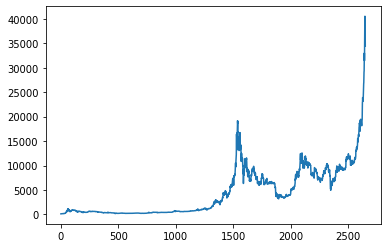

In [2]:
%matplotlib inline
plt.plot(df['Close'])
data = df.filter(['Close']).values

# Feature Scaling

* (X - min(X)) / ((max(X) - min(X))

In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))  # to avoid diversion and zero convergence 
                                             # 0 <= x <= 1, 0 <= y <= 1
                                             # cf. Standardization(Z-score)
scaled_data = scaler.fit_transform(data)
scaled_data

array([[3.72923481e-04],
       [4.17466207e-04],
       [0.00000000e+00],
       ...,
       [9.93553105e-01],
       [9.55217903e-01],
       [8.48807829e-01]])

In [4]:
import math

training_data_size = math.ceil(len(scaled_data) * 0.66)  # math.ceil: round ceiling function
                                                         # ex. math.ceil(1.2) = 2
                                                         # ex. math.ceil(-4.5) = -4
                                                         # ex. math.ceil(10.9) = 11
train_data = scaled_data[0: training_data_size]
train_data

array([[0.00037292],
       [0.00041747],
       [0.        ],
       ...,
       [0.17937901],
       [0.18104412],
       [0.18070922]])

In [5]:
x_train, y_train = [], []
set_size = 10

for i in range(set_size, len(train_data)):
    x_train.append(train_data[i - set_size: i, 0])
    y_train.append(train_data[i, 0])

In [6]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1740, 10, 1)

In [7]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

x_train.shape[1]

10

# Dense Layer
NN(Neural Network) Layer that connects input layer with output layer.   
You can find more info here: [https://keras.io/api/layers/core_layers/dense/](https://keras.io/api/layers/core_layers/dense/)

* options   

        __init__ (
            units,
            activation = None,
            use_bias = True,
            kernel_initializer = 'glorot_uniform',
            bias_iniotializer = 'zeros',
            kernel_regularizer = None, 
            bias_regularizer = None,
            activity_regularizer = None,
            kernel_constraint = None,
            bias_constraint = None,
            **kwargs
            )


# 1. Activation Function
### In Hidden Layer
* ReLU
    * solve gradient vanishing problem
* Leaky ReLU
    * solve gradient vanishing problem

### In Ouput Layer
* (None)
    * regression
* Sigmoid
    * binary classification
* Softmax
    * multi classification

# 2. Optimizer 
* SGD
* Adam
* RMSprop

# 3. Loss Function 
* MSE(Mean Squared Error)
* RMSE(Root Mean Squared Error)

In [17]:
# 1. by adding layers
# model_lstm = Sequential()  # makes layers in a linear form
# model_lstm.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# model_lstm.add(LSTM(50, return_sequences=False))
# model_lstm.add(Dense(25))
# model_lstm.add(Dense(1))

# 2. by making layer instance
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),  # first layer needs input_shape
                                                                         # input layer
                                                                         # 'input_shape=(1,)' == 'input_dim=1'
    LSTM(50, return_sequences=False),
    Dense(units=25), # hidden layer. units: batch_size
    Dense(units=1)   # output layer
])

model_lstm.compile(optimizer='adam', loss='mean_squared_error')  # method: optimizer, objective: loss

In [9]:
print(model_lstm.input_shape)
print(model_lstm.output_shape)

(None, 10, 1)
(None, 1)


In [10]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [11]:
model_lstm.fit(x_train, y_train, batch_size=1, epochs=1)

1740/1740 [==============================] - 8s 5ms/step - loss: 4.2504e-04


In [12]:
test_data = scaled_data[training_data_size - set_size:, :]

x_test = []
y_test = data[training_data_size:, :]

for i in range(set_size, len(test_data)):
    x_test.append(test_data[i - set_size: i, 0])

In [13]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [14]:
predictions = model_lstm.predict(x_test)

# unscaling
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

629.195860346725

In [15]:
predicted_data = df.filter(['Close'])

train = predicted_data[: training_data_size]
valid = predicted_data[training_data_size: ]
valid['Predictions'] = predictions
valid

<ipython-input-15-408a547ab8f3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


,Close,Predictions
1750,7730.247480,7865.032227
1751,8325.801534,8012.483887
1752,8271.597920,8212.394531
1753,7925.247396,8414.727539
1754,8254.277348,8555.290039
...,...,...
2646,39713.507857,31071.488281
2647,40519.448598,32163.126953
2648,40258.923989,33278.109375
2649,38709.765375,34205.195312


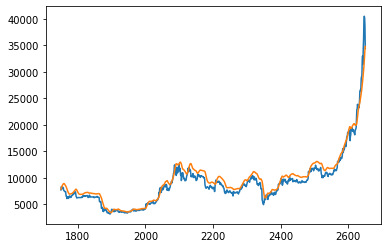

In [24]:
plt.plot(valid[['Close', 'Predictions']][:])

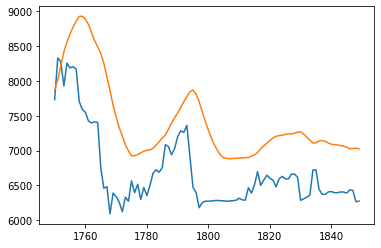

In [22]:
plt.plot(valid[['Close', 'Predictions']][:100])

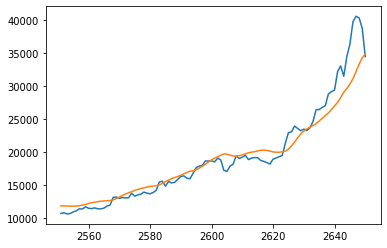

In [23]:
plt.plot(valid[['Close', 'Predictions']][-100:])